In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import itertools
import pandas as pd



In [2]:
RSV_data = np.array([[19.19,18.13,19.16], # RSV Gradient from Donovan-Banfield et al
          [15.26,10.23,10.67],
          [3.54,10.6,9.71],
          [9.5,11.06,10.23],
          [6.57, 9.63, 8.73],
          [4.02,4.01,4.18],
          [3.88,3.11,3.28],
          [2.32,4.89,3.90],
          [3.50,4.82,4.38],
          [0,.01,.01]])
RSV_data =RSV_data/np.sum(RSV_data, axis = 0)
RSV_data_mean = np.mean(RSV_data,axis = 1)
RSV_data_sd = np.std(RSV_data,axis = 1)
RSV_data_mean_norm = RSV_data_mean/np.sum(RSV_data_mean)
RSV_data_sd_norm = RSV_data_sd/np.sum(RSV_data_mean)
RSV_data_mean_norm



array([2.59397817e-01, 1.67528945e-01, 1.07194138e-01, 1.40843727e-01,
       1.13468605e-01, 5.60103269e-02, 4.73593395e-02, 5.02278547e-02,
       5.78807745e-02, 8.84720595e-05])

In [3]:
EBOV_data = np.array([[3322.50,3013.07,2345.22,1697.22,1079.27,583.89,228.20], # Ebola Gradient
                      [651.15,662.69,435.44,481.90,254.26,180.37,43.37]]).T
EBOV_data = EBOV_data/np.sum(EBOV_data, axis = 0)
EBOV_data_mean = np.mean(EBOV_data,axis = 1)
EBOV_data_sd = np.std(EBOV_data,axis = 1)
EBOV_data_mean_norm = EBOV_data_mean/np.sum(EBOV_data_mean)
EBOV_data_sd_norm = EBOV_data_sd/np.sum(EBOV_data_mean)
EBOV_data_mean_norm

array([0.25557289, 0.24509283, 0.17593594, 0.15810327, 0.09090793,
       0.05708329, 0.01730385])

In [4]:

MV_data = np.array([[851.14,688.19,492.81,387.58,336.48,210.84,48.06], # Marbug Gradient
                      [108.49,103.21,57.08,58.64,44.02,29.66,4.86]]).T
MV_data = MV_data/np.sum(MV_data, axis = 0)
MV_data_mean = np.mean(MV_data,axis = 1)
MV_data_sd = np.std(MV_data,axis = 1)
MV_data_mean_norm = MV_data_mean/np.sum(MV_data_mean)
MV_data_sd_norm = MV_data_sd/np.sum(MV_data_mean)
MV_data_mean_norm


array([0.27476777, 0.24124234, 0.15202615, 0.13649702, 0.11001631,
       0.07149471, 0.0139557 ])

In [5]:
# define list of virus names
viruses = ["RSV", "EBOV", "MV"]

# define list of virus genes and their orders
virus_gene_names = [ ["NS1", "NS2", "N", "P", "M", "SH", "G", "F", "M2", "L"],
                     ["NP", "VP35", "VP40", "GP", "VP30", "VP24", "L"],
                     ["NP", "VP35", "VP40", "GP", "VP30", "VP24", "L"]]
# define list of mean expression of each gene for each virus
virus_means = [RSV_data_mean_norm, EBOV_data_mean_norm, MV_data_mean_norm]

# define list of sd of expression of each gene for each virus. 0 implies that this was not available
virus_sd = [RSV_data_sd_norm, EBOV_data_sd_norm, MV_data_sd_norm]



In [6]:
RSV_genome_pos = np.array([576,1098,2327,3242,4209,4628,5595,7550,8557,15067])
RSV_genome_pos = np.array(RSV_genome_pos - np.min(RSV_genome_pos))
RSV_genome_pos

EBOV_genome_pos =  np.array([3026,4407,5894,8305,9740,11518,18282])
EBOV_genome_pos = np.array(EBOV_genome_pos - np.min(EBOV_genome_pos))
EBOV_genome_pos

MV_genome_pos =  np.array([2844,4410,5819,8670,10016,11285,19037])
MV_genome_pos = np.array(MV_genome_pos - np.min(MV_genome_pos))
MV_genome_pos


virus_genome_pos = [RSV_genome_pos, EBOV_genome_pos, MV_genome_pos]


In [7]:
overlaps = [[9],
            [2, 4, 6],
            [5]]

In [8]:
# objective function for fitting model

def obj_fun(x):
    p = x[0]
    p_trans = x[1]
    pred = np.array([p**x * p_trans for x in genome_pos])
    for t in ov:
        pred[ov] = pred[ov] * (1-p_trans)
    pred_norm = pred/np.sum(pred)
    mse = np.mean(( ( pred_norm-data_norm )/data_norm_sd )**2)
    return mse


In [9]:
# iterate through each virus and fit the model 100,000 times starting at random positions.

all_fits = []
all_funcs = []
for j in range(len(viruses)):
    fits = []
    funcs = []
    data_norm = np.array(virus_means[j])
    genome_pos = virus_genome_pos[j]
    ov = overlaps[j]
    data_norm_sd = np.array(virus_sd[j])
    for i in range(100000):
        res = minimize(obj_fun, np.random.random(2), bounds = [[0, 1]], tol = 1e-20)
        fits.append(res.x)
        funcs.append(res.fun)
        if i % 10000 == 0:
            print(i)
    all_fits.append(fits)
    all_funcs.append(funcs)
    print(viruses[j])
all_fits = np.array(all_fits)




0


<ipython-input-8-858dd87c846f>:9: RuntimeWarning: invalid value encountered in divide
  pred_norm = pred/np.sum(pred)


10000
20000
30000
40000
50000
60000
70000
80000
90000
RSV
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
EBOV
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
MV


In [1]:
# save fits and then generate and save a file with the 
# statistics assocaited with the top 100 fits for each virus

for i in range(len(viruses)):
    df = pd.concat( [pd.DataFrame(all_fits[i]) , pd.DataFrame(all_funcs[i])], axis = 1)
    df.columns = ["p(walk)", "ptransc", "WMSE"]
    df.to_csv(f"File3-All_Parameter_Fits_overlaps/{viruses[i]}_fits.csv")
    df = df.loc[np.array(df.iloc[:,-1]) > 0 ]
    df = df.loc[np.array(df.iloc[:,-1]) < np.quantile(np.array(df.iloc[:,-1]), 100/len(df.loc[np.array(df.iloc[:,-1]) > 0 ]))]
    df_stats = pd.DataFrame([np.mean(df.iloc[:,:-1], axis = 0), np.std(df.iloc[:,:-1], axis = 0), np.max(df.iloc[:,:-1], axis = 0), np.min(df.iloc[:,:-1], axis = 0), df[df.iloc[:,-1] == np.min(df.iloc[:,-1])].iloc[0,:-1]]).T
    df_mse = pd.DataFrame(2*[df[df.iloc[:,-1] == np.min(df.iloc[:,-1])].iloc[0,-1]])
    df_mse.index = ["p(walk)", "ptransc"]
    df_stats = pd.concat([df_stats, df_mse], axis = 1 )
    df_stats.columns = ["Mean of Top 100 Fit Estimates", "Std of Top 100 Fit Estimates", "Max of Top 100 Fit Estimates", "Min of Top 100 Fit Estimates", "Best Fit Estimate", "Best Fit WMSE"]
    df_stats.index = ["p(walk)", "ptransc"]
    df_stats.to_csv(f"File4-Top_100_Fit_Stats_overlaps/{viruses[i]}_fits.csv")
    
    


NameError: name 'viruses' is not defined

In [11]:
# Get the best fit parameter

dfs = pd.DataFrame()
for i in range(len(viruses)):
    df = pd.read_csv((f"File4-Top_100_Fit_Stats_overlaps/{viruses[i]}_fits.csv"))
    dfs = pd.concat([dfs, df])
best_fit_pars = dfs.iloc[:,-2]
best_fit_pars = [best_fit_pars[0:2], best_fit_pars[2:4], best_fit_pars[4:6], best_fit_pars[6:8]]



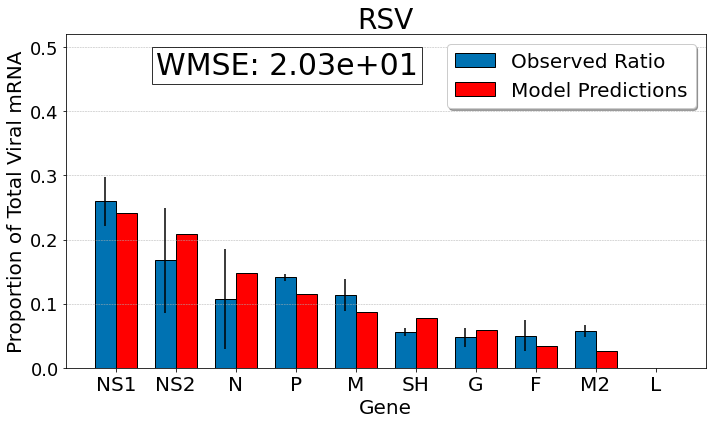

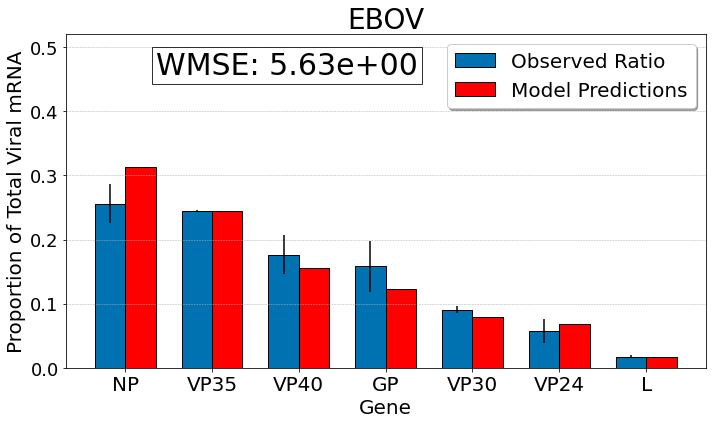

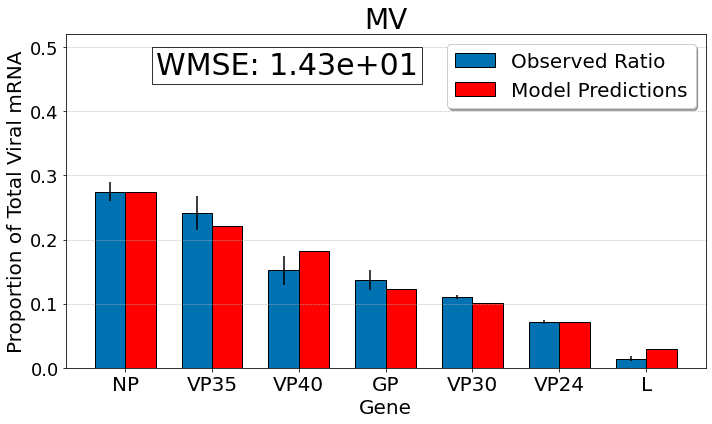

In [15]:
# Generate barplots of observed gradients and predicted gradients

for i in range(len(viruses)):
    genome_pos = virus_genome_pos[i]    
    pars = best_fit_pars[i]
    ov = overlaps[i]
    p = pars[0]
    p_trans = pars[1]
    
    data_norm_sd = np.array(virus_sd[i])

    pred = np.array([p**x * p_trans for x in genome_pos])
    for t in ov:
        pred[ov] = pred[ov] * (1-p_trans)
    pred_norm = pred/np.sum(pred)    
    categories = virus_gene_names[i]
    indices = np.arange(len(categories))
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    # Create bars
    bar_width = 0.35
    ax.set_title(f'{viruses[i]}', fontsize=28)
    # Create bars for virus_means[i]
    ax.bar(indices - bar_width/2, virus_means[i], width=bar_width, yerr= 2 * np.array(virus_sd[i]), color='#0072B2', edgecolor='black', label='Observed Ratio')
    # Increase y-axis label size
    ax.tick_params(axis='y', labelsize=18)
    # Create bars for pred_norm
    ax.bar(indices + bar_width/2, pred_norm, width=bar_width, color='red', edgecolor='black', label='Model Predictions')
    # Set legend with improved positioning and styling
    ax.legend(loc='best', fontsize=20, frameon=True, shadow=True)
    # Set labels, title, and ticks
    ax.set_xticks(indices)
    plt.ylim([0,.52])
    mse = np.format_float_scientific(np.mean( ( (np.array(pred_norm) - np.array(virus_means[i]) ) / np.array(virus_sd[i])  )**2 ), precision=2)
    ax.set_xticklabels(categories, fontsize=20)
    ax.set_ylabel('Proportion of Total Viral mRNA', fontsize=20)
    ax.set_xlabel('Gene', fontsize=20)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    
    ax.text(0.55, 0.95, f'WMSE: {mse}', transform=ax.transAxes, fontsize=30,
            verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(f"Figures/Fig3/{viruses[i]}_Gradients.svg")
    plt.show()   
    
    
    

In [13]:
dfs = pd.DataFrame()
for i in range(len(viruses)):
    df = pd.read_csv((f"File4-Top_100_Fit_Stats_overlaps/{viruses[i]}_fits.csv"))
    dfs = pd.concat([dfs, df])
    
ind = [2 * [x] for x in viruses]
inds = []

for i in ind:
    inds += i
dfs.index = inds
dfs = dfs.iloc[::2]
dfs.iloc[:,0] = viruses
1 / (1-dfs.iloc[:,1])

RSV     3585.373009
EBOV    5621.390225
MV      7217.021135
Name: Mean of Top 100 Fit Estimates, dtype: float64

In [14]:

dfs = pd.DataFrame()
for i in range(len(viruses)):
    df = pd.read_csv((f"File4-Top_100_Fit_Stats_overlaps/{viruses[i]}_fits.csv"))
    dfs = pd.concat([dfs, df])
ind = [2 * [x] for x in viruses]
inds = []
for i in ind:
    inds += i
dfs.index = inds
print(1 / (1-dfs.iloc[::2,1]))
dfs.iloc[:,2] = dfs.iloc[:,2].apply(lambda x: '{:.2e}'.format(x))
dfs.iloc[:,-1] = dfs.iloc[:,-1].apply(lambda x: '{:.2e}'.format(x))
dfs = dfs.round(5)
dfs.columns = ["Parameter"] + list(dfs.columns)[1:]
dfs.to_csv("File4-Top_100_Fit_Stats_overlaps/All_Viruses_Processivities_Overlap_Gradient.csv")
dfs


RSV     3585.373009
EBOV    5621.390225
MV      7217.021135
Name: Mean of Top 100 Fit Estimates, dtype: float64


,Parameter,Mean of Top 100 Fit Estimates,Std of Top 100 Fit Estimates,Max of Top 100 Fit Estimates,Min of Top 100 Fit Estimates,Best Fit Estimate,Best Fit WMSE
RSV,p(walk),0.99972,1.75e-10,0.99972,0.99972,0.99972,2.03e+01
RSV,ptransc,0.97934,3.65e-07,0.97934,0.97934,0.97934,2.03e+01
EBOV,p(walk),0.99982,3.13e-08,0.99982,0.99982,0.99982,5.63e+00
EBOV,ptransc,0.06081,5.73e-05,0.06092,0.06075,0.06092,5.63e+00
MV,p(walk),0.99986,1.43e-09,0.99986,0.99986,0.99986,1.43e+01
MV,ptransc,0.16779,1.49e-05,0.16782,0.16777,0.16781,1.43e+01
